In [59]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def partial_spearman_corr(df, x, y, controls):
    """Compute partial Spearman correlation between x and y given selected control variables."""
    from statsmodels.api import OLS, add_constant
    
    if controls:
        # Regress x and y on control variables
        residual_x = OLS(df[x], add_constant(df[controls])).fit().resid
        residual_y = OLS(df[y], add_constant(df[controls])).fit().resid
        return spearmanr(residual_x, residual_y)[0]
    else:
        return spearmanr(df[x], df[y])[0]

In [60]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_causal_graph(adj_matrix, df, ci_test):
    """
    Plots causal graph with edge color based on partial Spearman correlation values.
    Uses only relevant control variables.
    Displays actual correlation values (+/-0.XX) beside the edges.
    Draws arrows for one-way edges and lines for undirected (symmetric) edges.
    """
    nodes = df.columns
    G = nx.DiGraph()
    edge_info = []
    edge_labels = {}

    # Loop through all pairs
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if adj_matrix[i, j] != 0:
                node_i = nodes[i]
                node_j = nodes[j]

                # Identify control variables
                related_vars = [nodes[k] for k in range(len(nodes)) if adj_matrix[k, j] or adj_matrix[k, i]]
                controls = [var for var in related_vars if var not in [node_i, node_j]]

                # Compute partial Spearman correlation
                pcorr = partial_spearman_corr(df, node_i, node_j, controls)

                # Determine edge color and width
                edge_color = '#F2C14E' if pcorr > 0 else '#8e7dbe'
                edge_width = 1 + 2 * abs(pcorr)

                G.add_edge(node_i, node_j, weight=pcorr)
                edge_info.append((node_i, node_j, edge_color, edge_width))
                edge_labels[(node_i, node_j)] = f"{pcorr:+.2f}"

    pos = nx.circular_layout(G)
    label_pos = {n: (p[0] * 1.2, p[1] * 1.2) for n, p in pos.items()}

    plt.figure(figsize=(11, 11), dpi=900)
    node_colors = ['#C9BFE1']  # default purple

    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        edgecolors='white',
        node_size=500,
        alpha=0.9
    )
    nx.draw_networkx_labels(G, label_pos, font_size=16, font_family="arial", font_color='black')

    # Draw edges: check for symmetric edges
    handled_edges = set()
    for u, v, color, width in edge_info:
        if (v, u) in handled_edges:
            continue  # already handled symmetric pair

        arc_rad = 0.1

        if G.has_edge(v, u):
            
            # symmetric → undirected style
            nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)], width=width, edge_color=color,
            arrowstyle='-', arrowsize=20, connectionstyle=f'arc3,rad={arc_rad}',
            min_source_margin=20, min_target_margin=20
            )
            handled_edges.add((u, v))
        else:
            # one-way → directed arrow
            nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)], width=width, edge_color=color,
            arrowstyle='simple', arrowsize=20, connectionstyle=f'arc3,rad={arc_rad}',
            min_source_margin=20, min_target_margin=20
            )
            handled_edges.add((u, v))

    # Edge labels
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=14,
        font_color='black',
        font_family="arial",
        rotate=True,
        label_pos=0.5,
        bbox=dict(facecolor='none', edgecolor='none', pad=0)
    )

    # Legend
    pos_patch = mpatches.Patch(color='#F2C14E', label='Positive Causality')
    neg_patch = mpatches.Patch(color='#8e7dbe', label='Negative Causality')
    plt.legend(handles=[pos_patch, neg_patch], loc='lower left', fontsize=14, frameon=False)

    plt.gca().margins(x=0.3, y=0.3)
    plt.axis('off')
    plt.show()

In [61]:
import numpy as np
import pandas as pd
from pc_gcastle import PC
from random import shuffle

def run_pc_analysis(df, factor_list, alpha=0.05, shuffle_factors=False, ci_test='spearman'):
    """
    Run PC algorithm for a selected subset of factors.
    
    Parameters:
        df (pd.DataFrame): Original dataframe containing 'factor', 'cbsacode', and 'SSAMI'.
        factor_list (list): List of factor names to include in the analysis.
        alpha (float): Significance level for conditional independence tests.
        shuffle_factors (bool): Whether to shuffle the factor list randomly.
    
    Returns:
        pc (PC object): The trained PC model.
    """
    
    if shuffle_factors:
        shuffle(factor_list)
    
    # Filter and pivot
    df_select = df.loc[df['factor'].isin(factor_list)]
    sami_col = df_select.columns[df_select.columns.str.contains("SAMI", case=False)][0]

    dfp = df_select.pivot(index=["cbsacode",'Year'], columns="factor", values=sami_col).reset_index()
    df_cleaned = dfp.drop(columns=["cbsacode",'Year'])  # Reverse column order as in original code
    data_matrix = df_cleaned.to_numpy()

    # Run PC algorithm
    pc = PC(variant='stable', alpha=alpha, ci_test = ci_test)
    pc.learn(data_matrix, columns=df_cleaned.columns)

    result = pc._results
    
    print("Learned skeleton (CPDAG):")
    plot_causal_graph(pc.causal_matrix, df_cleaned,ci_test)
    
    return result

In [62]:
my_factors = ['Depression',
    # health
    # 'excessive_drinking',
    # 'adult_obesity',
    # 'sti', 
    'Unhealthy Lifestyle',
    # 'smo_obe', 
    # 'smo_dia', 
    # 'obe_dia', 
    'Physical Inactivity', 

    # education
    # 'some_college',

    # economic
    # 'unemployment', #no direct link with depression
    'GDP', 
    # 'median_household_income', #add this the no time activity become result

    # health source
    'Mental Health Providers', 

    # social association
    # 'children_single_parent',

    # enviroment
    # 'driving_alone_to_work', 
    'Park Area',
    # 'Weighted_RESP', 
    # 'noise70n', 
    # 'noise80n', 
    'Noise', 
    
]

# SASAMI

In [63]:
df = pd.read_csv('../00_data/03_analysis_data/sasami_result_0403.csv')
df.loc[df['factor'] == 'Park_Area_Acres', 'factor'] = 'PARK'
df.loc[df['factor'] == 'noise90n', 'factor'] = 'NOI'
df.loc[df['factor'] == 'no_time_activity', 'factor'] = 'PI'
df.loc[df['factor'] == 'smo_obe_dia', 'factor'] = 'UNH'
df.loc[df['factor'] == 'depressed', 'factor'] = 'DEP'
df.loc[df['factor'] == 'gdp', 'factor'] = 'GDP'
df.loc[df['factor'] == 'mental_health_providers', 'factor'] = 'MHP'

In [69]:
my_factors = ['GDP','NOI','PARK','PI','UNH','DEP','MHP']

In [65]:
pc_result= run_pc_analysis(df, factor_list=my_factors, alpha=0.01, shuffle_factors=True,ci_test='spearman')

Learned skeleton (CPDAG):


In [12]:
my_factors

['PARK', 'NOI', 'PI', 'UNH', 'DEP', 'GDP', 'MHP']

In [13]:
pc_result

[(0, 1, [], -0.20674053781710228, 8.542704680088913e-10),
 (0, 2, [], 0.20973157146992868, 4.807472605527476e-10),
 (0, 3, [], 0.18717385301252146, 2.9757470454803297e-08),
 (0, 4, [], 0.012238286183356142, 0.7194280176371604),
 (0, 5, [], 0.2603951168832715, 7.397170077344825e-15),
 (0, 6, [], -0.08229352953915745, 0.015540627538721898),
 (1, 2, [], 0.20612499451138688, 9.605382317722535e-10),
 (1, 3, [], -0.06032202689823527, 0.07637044993061326),
 (1, 4, [], -0.15535243966060647, 4.481991681183321e-06),
 (1, 5, [], -0.23287109908453651, 4.191354269239629e-12),
 (1, 6, [], 0.01857326200741093, 0.5856181481315514),
 (2, 3, [], 0.03535032675492335, 0.29931509981054355),
 (2, 4, [], 0.00210777626701377, 0.9506694718943163),
 (2, 5, [], -0.16627719840350197, 8.891502554475945e-07),
 (2, 6, [], -0.0042274972445301776, 0.9012494074508887),
 (3, 4, [], -0.0726357251675287, 0.0327793958736805),
 (3, 5, [], 0.06448398777531394, 0.05813712765390492),
 (3, 6, [], 0.04524586222624206, 0.18394485

In [28]:
records = []
for (x_idx, y_idx,cond_indices,corr, p_val ) in pc_result:
    # Convert x_idx and y_idx to factor names:
    x_name = my_factors[x_idx]
    y_name = my_factors[y_idx]
    # Convert conditioning indices (if any) to factor names:
    cond_names = [my_factors[z] for z in cond_indices]

    records.append({
        "X": x_name,
        "Y": y_name,
        "Z":  cond_names,
        "Spearman":corr,
        "p value": p_val
    })

df = pd.DataFrame(records)


In [19]:
df.to_csv("../00_data/04_output/sasami_result.csv",index=False)

In [35]:
import pandas as pd
import ast

# Load your CSV
df = pd.read_csv("../00_data/04_output/sasami_result.csv")


# Clean Z column
def clean_z(z):
    try:
        items = ast.literal_eval(z)
        if isinstance(items, list) and len(items) == 0:
            return '-'
        elif isinstance(items, list):
            return ', '.join(str(i) for i in items)
    except:
        return z
    return z

# Apply formatting
df['Z'] = df['Z'].apply(clean_z)
df['Spearman'] = df['Spearman'].astype(float).apply(lambda x: f"{x:.2f}")
df['p value'] = df['p value'].astype(float).apply(lambda x: r"\textless{} 0.001" if x < 0.001 else f"{x:.3f}")

# Split side by side
half = len(df) // 2 + len(df) % 2
df1 = df.iloc[:half].reset_index(drop=True)
df2 = df.iloc[half:].reset_index(drop=True)
combined = pd.concat([df1, df2], axis=1)
combined.columns = ['X', 'Y', 'Z', 'Spearman', 'p value', 'X', 'Y', 'Z', 'Spearman', 'p value']

# Export to LaTeX
latex_code = combined.to_latex(
    index=False,
    column_format="|l|l|l|r|r||l|l|l|r|r|",
    escape=False
)

In [36]:
with open("sasami_table_final.tex", "w") as f:
    f.write(latex_code)

In [ ]:
pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.01, shuffle_factors=True,ci_test='mutual_info')

ci_test is now: mutual_info
Learned skeleton (CPDAG):


# Density

In [ ]:
df2 = pd.read_csv('../00_data/03_analysis_data/sami_result_0403.csv')

ci_test is now: spearman
Learned skeleton (CPDAG):


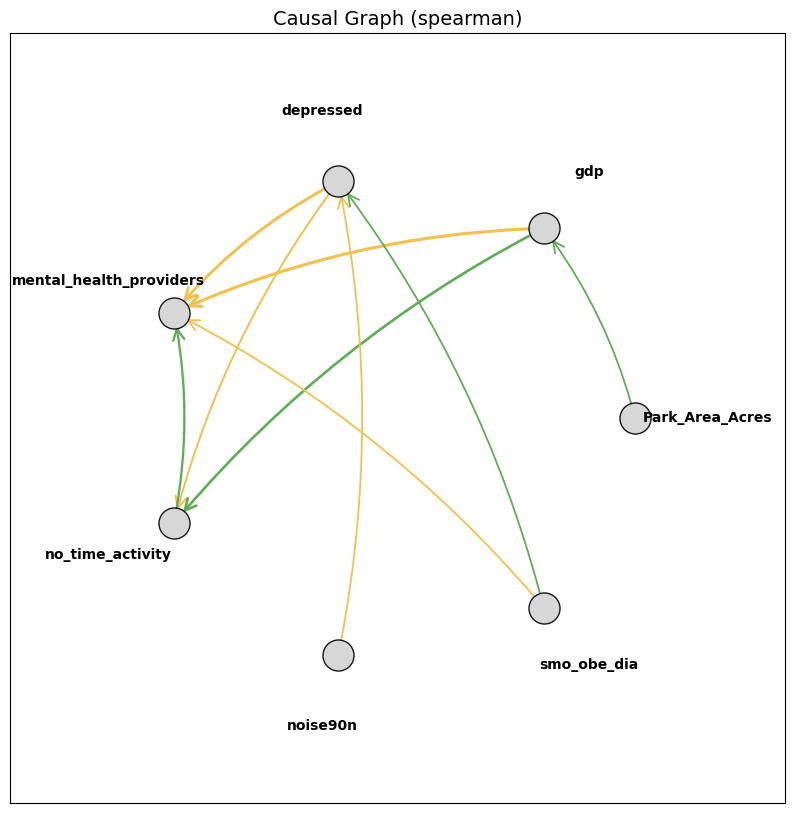

In [ ]:
pc_result = run_pc_analysis(df2, factor_list=my_factors, alpha=0.05, shuffle_factors=True,ci_test='spearman')

ci_test is now: mutual_info
Learned skeleton (CPDAG):


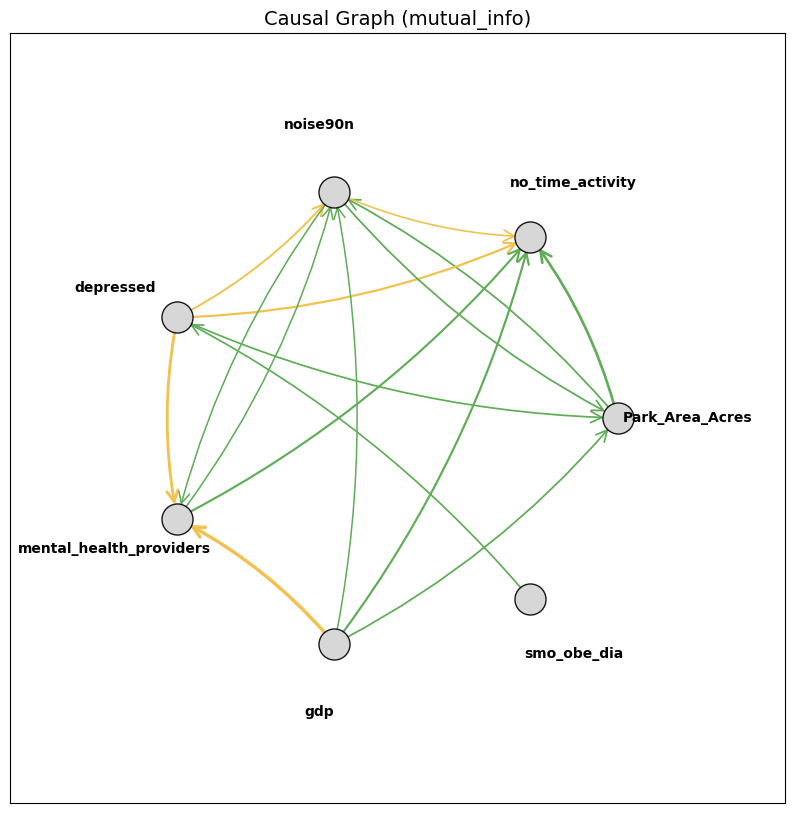

In [ ]:
pc_result = run_pc_analysis(df2, factor_list=my_factors, alpha=0.01, shuffle_factors=True,ci_test='mutual_info')

---